This notebook trains a multiclass classifier on the selected dataset. It's not meant to train an accurate classifier, but rather use it as a tool to asses the quality of your dataset. Train first a model on your original dataset, and then a new dataset resulting from the removal of the DBSCAN outliers. Keep architecture and training procedures equal for both datasets for better comparasions.

Add -> full crossvalidation

In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import tensorflow as tf
from keras.callbacks import ModelCheckpoint

2022-11-16 10:49:00.837256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Content directory and image dimension
img_folder = 'Cleaned_Data_512_pca_10'
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Define your model name to be saved
model_name = 'classifier_cleaned_512_PCA_10_data'

In [3]:
def create_dataset(img_folder):
    img_data_array = []
    class_name = []
    file_list = []
    
    for dir1 in tqdm(os.listdir(img_folder)):
        if dir1 == '.DS_Store':
            print('Ignoring .DS_Store')
        else:
            for file in os.listdir(os.path.join(img_folder, dir1)):
                image_path = os.path.join(img_folder, dir1, file)
                if file == '.DS_Store':
                    continue
                else:
                    image = cv2.imread(image_path)[:,:,::-1]
                    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
                    image = np.array(image)
                    image = image.astype('float32')
                    image /= 255
                    img_data_array.append(image)
                    class_name.append(dir1)
                    file_list.append(file)
    return img_data_array, class_name, file_list

In [4]:
# extract the image array and class name
img_data, class_name, _ =  create_dataset(img_folder)

# Dictionary for class names
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}

# convert class_names to their values
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]
num_classes = len(np.unique(class_name))

# As list and shuffle
img_data = np.asarray(img_data)
zipped = list(zip(img_data,target_val))

# shuffle
random.seed(10)
random.shuffle(zipped)
img_data, target_val = zip(*zipped)

# Split into train-val-test 
# train and test sets
split_ratio = 0.85
X = np.asarray(img_data[:int(split_ratio*len(img_data))])
y = np.asarray(target_val[:int(split_ratio*len(img_data))])
X_test = np.asarray(img_data[int(split_ratio*len(img_data)):])
y_test = np.asarray(target_val[int(split_ratio*len(img_data)):])

# train and val sets
split_ratio_val = 0.85
X_train = np.asarray(X[:int(split_ratio_val*len(X))])
y_train = np.asarray(y[:int(split_ratio_val*len(X))])
X_val = np.asarray(X[int(split_ratio_val*len(X)):])
y_val = np.asarray(y[int(split_ratio_val*len(X)):])

100%|████████████████████████████████████████████| 8/8 [00:11<00:00,  1.39s/it]


In [5]:
# Architecture. Not ideal
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

2022-11-16 10:49:32.968327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# training classifier
EPOCHS = 10

# Compile
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Using callbacks to save best val performance model
filepath = model_name + '.h5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss', # change to val_accuracy if preferred 
                             verbose=1,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

# training
history = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=EPOCHS,
  callbacks=callbacks
)

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 1.5933 - accuracy: 0.4518
Epoch 1: val_loss improved from inf to 1.28154, saving model to classifier_cleaned_512_PCA_10_data.h5
146/146 [==============================] - 76s 506ms/step - loss: 1.5933 - accuracy: 0.4518 - val_loss: 1.2815 - val_accuracy: 0.5827
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 1.1614 - accuracy: 0.6140
Epoch 2: val_loss improved from 1.28154 to 1.05504, saving model to classifier_cleaned_512_PCA_10_data.h5
146/146 [==============================] - 105s 718ms/step - loss: 1.1614 - accuracy: 0.6140 - val_loss: 1.0550 - val_accuracy: 0.6387
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.6656
Epoch 3: val_loss improved from 1.05504 to 0.99223, saving model to classifier_cleaned_512_PCA_10_data.h5
146/146 [==============================] - 82s 565ms/step - loss: 0.9941 - accuracy: 0.6656 - val_loss: 0.9922 - val_accuracy: 0.

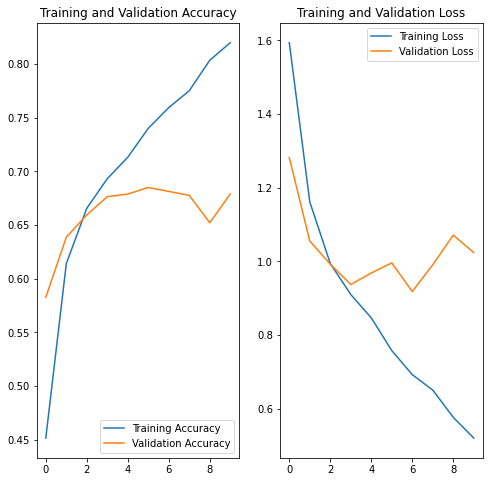

In [7]:
# Training Visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('training_' + model_name + '.png')
plt.show()

31/31 [==============================] - 4s 137ms/step - loss: 0.9934 - accuracy: 0.7001
test loss, test acc: [0.9933717846870422, 0.7001034021377563]
31/31 [==============================] - 4s 122ms/step


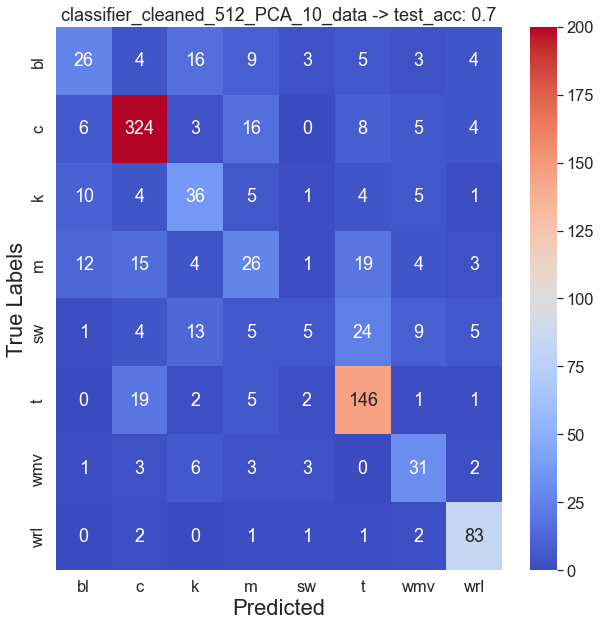

In [8]:
import seaborn as sn
import sys
np.set_printoptions(threshold=sys.maxsize)
from sklearn.metrics import confusion_matrix
import pandas as pd

load_model = False # swith to true if you wish to load a previous model

if load_model:
    filepath =  model_name + '.h5'
    model = tf.keras.models.load_model(filepath)

    # Compile
    model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

# Evaluate on test data
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

# To further visualize results, we apply softmax to the model's output
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)

# the prediction for each test image is the one of highest softmax probability
y_preds = [np.argmax(predictions[i]) for i in range(len(predictions))]

# building confusion matrix and transforming it to pandas to work with seaborn
conf_matrix = confusion_matrix(y_test,y_preds)
df = pd.DataFrame(conf_matrix, columns = target_dict, index = target_dict)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10))
sn.set(font_scale=1.5)

sn.heatmap(df,
            cmap='coolwarm',
            annot=True,
            fmt='.5g',
            vmax=200)

plt.xlabel('Predicted',fontsize=22)
plt.ylabel('True Labels',fontsize=22)
plt.title(model_name + ' -> test_acc: ' + str(round(results[1],2)))
plt.savefig('confusion_plot_' + model_name + '.png')